# Where I am going to be adding my own code that makes the flux curves for the SNR

In [18]:
#cell where I view snr properties as I develop
snr_valid_SG_list[3].Snu1GHz

310.0

In [61]:
#function that takes the SNR object and returns the flux density at a time since the SNe exploded
#NEED TO MAKE THIS ALSO A FCN OF FREQUENCY
def S_nu_1GHz(snr, t, freq):
    
    p = snr.p
    Snu1GHz = snr.Snu1GHz * 1e-23 #converting to cgs
    tn = snr.tn * 365.25 * 24 * 3600 #converting to seconds
    A = Snu1GHz*(tn**(4*p/5))#const of proportionality for Sedov-Taylor flux evolution
    
    tf = 100 * 365.25 * 24 * 3600 #converting to seconds, letting free expansion phase always be 100 yrs
    free_expansion = A*tf**(-4*p/5)
    
    if t <= tf:
        one_GHz_flux = free_expansion
        B = one_GHz_flux * (10**9)**(snr.si)
        this_flux = B * freq**(-1*snr.si)
        return this_flux
    
    elif t > tf and t <= tn:
        one_GHz_flux = A * t**(-4*p/5)
        B = one_GHz_flux*(10**9)**(snr.si) #getting constant of proportionality
        this_flux = B * freq**(-1*snr.si)
        return this_flux
    
    else:
        return None

In [65]:
S_nu_1GHz(w50, w50.tn*365.25*24*3600, 1e9)

8.5e-22

In [64]:
w50.Snu1GHz

85.0

In [ ]:
S_nu propto t^(-4p/5)

In [48]:
S_nu_1GHz(snr_valid_SG_list[3], 10, 406e6)

2.459493391902223e-17

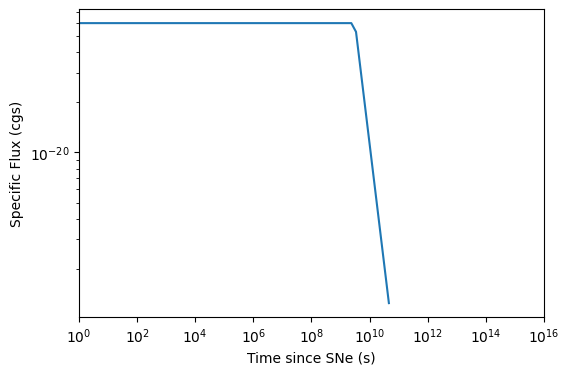

In [49]:
power = 16
t = np.logspace(0,power,100)
S_nu = np.ones(len(t))
for i in range(len(t)):
    S_nu[i] = S_nu_1GHz(snr_valid_SG_list[81], t[i], 406e6)
plt.plot(t, S_nu)
plt.xlim([1,10**power])
plt.loglog()
plt.ylabel('Specific Flux (cgs)')
plt.xlabel('Time since SNe (s)');

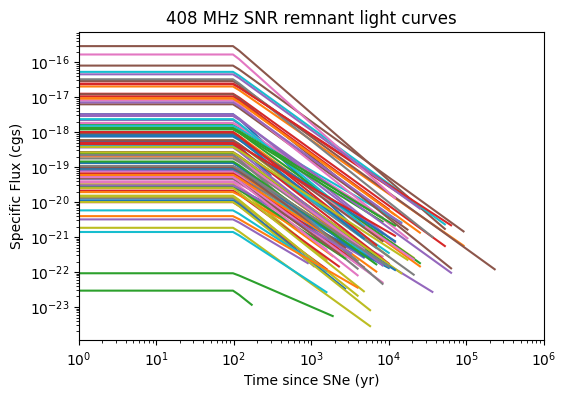

In [50]:
#plotting all SNR light curves as fcn of time
power = 16
t = np.logspace(0,power,200)
for snr in snr_valid_SG_list:
    S_nu = np.ones(len(t))
    for i in range(len(t)):
        S_nu[i] = S_nu_1GHz(snr, t[i], 408e6)
    plt.plot(t/(3600*24*365.25), S_nu)
        
plt.xlim([1,10**6])
plt.loglog()
plt.ylabel('Specific Flux (cgs)')
plt.xlabel('Time since SNe (yr)');
plt.title("408 MHz SNR remnant light curves");

# test cell where we compare with YK's paper on SNR light curves

[5.615615737222397e-22, 83.89999999999998, 3.3, 22.26109485192302]
[7.116391568871533e-23, 186.4, 0.1, 10.285762331523062]
[3.6574523444449155e-22, 219.7, 2.0, 7.639000828708477]


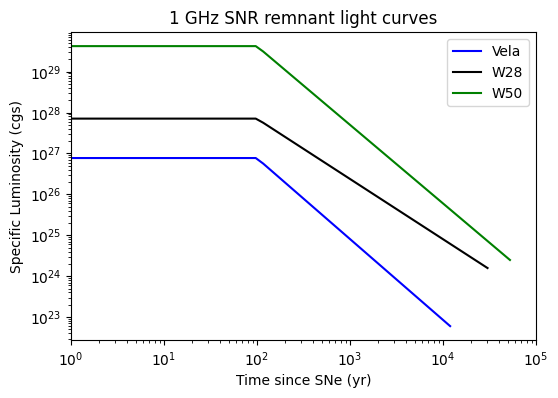

In [51]:
vela = get_snr('Vela', snr_valid_SG_list)
w28 = get_snr('W28', snr_valid_SG_list)
w50 = get_snr('W50', snr_valid_SG_list)
test_snrs = [[vela,'b'], [w28,'k'], [w50,'g']]

#plotting all SNR light curves as fcn of time
power = 16
t = np.logspace(0,power,200)
colors = ['b','r','g']
for snr in test_snrs:
    print(SNR_gegenschein(snr[0], 1e9, 4.1194e-8))
    S_nu = np.ones(len(t))
    for i in range(len(t)):
        S_nu[i] = S_nu_1GHz(snr[0], t[i], 1e9)
        
        if S_nu[i]!=None: #multiplying non None values by 4 pi d^2 to get luminosity
            S_nu[i] = S_nu[i] * 4 * np.pi * (snr[0].d*3.086e21)**2
    
    plt.plot(t/(3600*24*365.25), S_nu, snr[1])
        
plt.xlim([1,10**5])
plt.loglog()
plt.ylabel('Specific Luminosity (cgs)')
plt.xlabel('Time since SNe (yr)');
plt.legend(["Vela","W28","W50"])
plt.title("1 GHz SNR remnant light curves");

# Putting in function for the NFW profile to give DM depth at various points. 

In [66]:
#I think that the units work out on this calculation because we still integrate along Kpc and end up with a 2D
#density in the other notebook for the column integral. I believe that this unit conversion, since it's a
#multiplicative factor will give the cgs result properly. 

In [66]:
#NFW profile DM function from Yitian's notebook
def NFW_profile(r): #g/cm^3(kpc)
    return 1/( (r/16)*(1+r/16)**2 ) * 9.653726724487642e-25 # * 3.08568e21

# Need to think about whether this function that gives g/cm^2 in the column integral works for keeping the intergal in cgs (I think it does since the only reason I factored it out last time was due to no time dependence in the source)

In [67]:
#function that takes Galactic R, lon, lat and returns distance to galactic center
def r(Gr, Glon, Glat): #takes Gr in kpc and Glon, Glat in degrees
    RS = 8.22 #kpc from galactic center to sun
    Glon_rad = np.radians(Glon)
    Glat_rad = np.radians(Glat)
    Dx = RS - Gr*np.cos(Glat_rad)*np.cos(Glon_rad)
    Dy = Gr*np.cos(Glat_rad)*np.sin(Glon_rad)
    Dz = Gr*np.sin(Glat_rad)
    return(np.sqrt(Dx**2 + Dy**2 + Dz**2))

In [68]:
#function to serve as integrand in column integral
def NFW_integrand(Gr, Glon, Glat):
    return( NFW_profile(r(Gr, Glon, Glat)) )

#I think that we won't need to worry about divergence that happens at galactic center since the healpix pixel's
#center for NSIDE=512 in this direction is actually slightly off from pointing right at the center of the galaxy

In [69]:
#helper function that computes the opposite direction angle from the angle entered
def opposite(point): #takes longitude and latitude in degrees point = [lon, lat]
    return(((point[0]+180)%360, -1*point[1]))

In [70]:
def SNR_integrand(xd, snr, tn, c, freq, glon_image, glat_image):
    return(S_nu_1GHz(snr, tn - 2*xd/c, freq)*NFW_integrand(xd/3.086e21, glon_image, glat_image)) #conv. xd to kpc


In [71]:
#function that takes the snr object and computes the gegenschein intensity based on the DM integral, as well
#as returning the location of the gegenschein image, and the size of the gegenschein image in arcmin
def SNR_gegenschein(snr, freq, g_ayy):
    #getting location of SNR in galactic coords
    glon = snr.l
    glat = snr.b
    glon_image, glat_image = opposite([glon, glat])
    tn = snr.tn * 365.25 * 24 * 3600 #age of SNR in seconds
    c = 2.99792458e10 # speed of light in cm per second
    
    
    integral = integrate.quad(SNR_integrand, 0, tn*c/2, args=(snr, tn, c, freq, glon_image, glat_image))[0]
    i_g = 6.62607015e-27*(1/(2*np.pi))*((2.9979245800e10)**4)*((g_ayy**2)/16)*integral
    
    return([i_g, glon_image, glat_image, snr.image_sigma])

# check gegenschein signal for each SNR
# do what YK did in SNR paper for free expansion phase (shorter free expansion phase same age)
# compare with YK paper for SNR remnants
# , sprinkle them on Haslam map

In [72]:
test_snrs = [vela, w28, w50]
for i in test_snrs:
    print(SNR_gegenschein(i, 408e6, 4.1194e-8))

[1.0853308869099733e-21, 83.89999999999998, 3.3, 22.26109485192302]
[1.0370091012837221e-22, 186.4, 0.1, 10.285762331523062]
[6.85040995198452e-22, 219.7, 2.0, 7.639000828708477]


In [73]:
np.sqrt(hp.nside2pixarea(512, degrees=True))*60 #arcmin of the 

6.870972823634811

In [90]:
to_put_onto_sky = []
for i in snr_valid_SG_list:
    to_put_onto_sky.append(SNR_gegenschein(i, 408e6, 4.1194e-8))
to_put_onto_sky

[[1.955294106194446e-23, 180.0, -0.0, 2.829784923955499],
 [2.4703327016800236e-25, 180.9, -0.1, 2.816771360613106],
 [1.518818252160568e-28, 181.9, -0.3, 2.665490483338941],
 [1.0370091012837221e-22, 186.4, 0.1, 10.285762331523062],
 [2.9101757314168225e-26, 187.7, 3.7, 3.489719266756493],
 [3.265423603147244e-23, 188.7, 0.1, 5.075865522650953],
 [2.8959733328705247e-25, 191.2, 0.3, 2.7719534139101465],
 [6.120677620558494e-25, 195.4, -0.1, 3.0630114723534834],
 [1.08534513591062e-25, 195.9, -0.2, 2.755179006762611],
 [7.867440650145664e-26, 196.7, -0.1, 2.7305721720764384],
 [4.523498377961149e-25, 198.1, 0.1, 3.132878690598666],
 [3.437392807590011e-23, 198.8, -0.3, 5.567138266982571],
 [9.348851625785528e-25, 198.9, 1.1, 4.341325608934689],
 [7.902815002578292e-26, 201.5, 0.9, 2.826031615183298],
 [1.413258095680485e-23, 201.8, 0.6, 3.48150189119728],
 [1.08229393954047e-22, 203.3, 0.3, 11.81213612003298],
 [4.929245204576098e-25, 204.7, -0.6, 4.23051592994433],
 [9.011510530814647

In [88]:
#cell that saves SNR parameters at different frequencies
freqs = np.linspace(50e6, 3e9, 50)

for j in freqs:
    to_put_onto_sky = []
    for i in snr_valid_SG_list:
        to_put_onto_sky.append(SNR_gegenschein(i, j, 4.1194e-8))
    np.savez("../../../freq_scaling/SNRs/SNRs_at_%f_Hz"%(j),to_put_onto_sky)

# Now I just need to put these images onto the sky
# this is code that will put the SNR images onto the sky

In [75]:
# function that takes location, size, and intenisty of image and returns the indices to add to and the intensity to 
# add to each
def add_to_sky(shine, glon, glat, arcmin_radius, NSIDE):
    radian_radius = 2*(arcmin_radius/60)*(np.pi/180) #times 2 since Std Dev of a gaussian
    
    #making a normalized vector that points in the direction of gegenshcien to get a disk
    vec_0 = hp.ang2vec(glon, glat, lonlat=True)
    disk_points = hp.query_disc(NSIDE, vec = vec_0, radius = radian_radius, inclusive = True)
    
    num_pts = len(disk_points)
    tot_area = num_pts * hp.nside2pixarea(512)
    per_pixel_shine = shine/tot_area
    
    return([disk_points, per_pixel_shine])

In [76]:
def SNR_on_map(Ig_map, disk_points, per_pixel_shine):
    Ig_map[disk_points] += per_pixel_shine
    return(Ig_map)

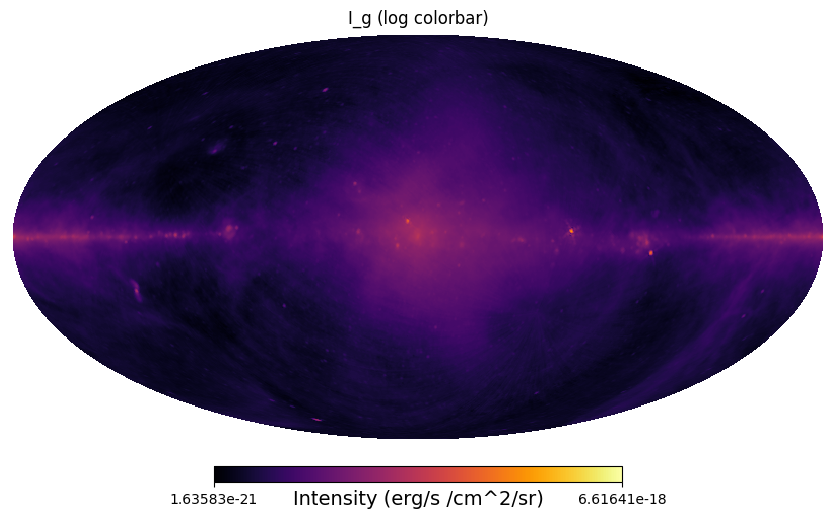

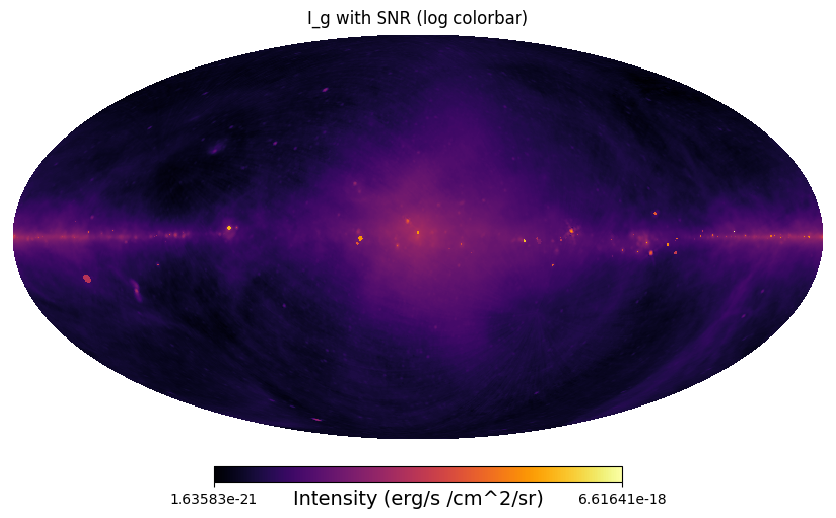

In [84]:
# loading in and plotting Haslam Map
I_g = np.load('/Users/harpersewalls/Desktop/SURA/Haslam_static_map/sky_maps/gegenschein_goodunits.npz')['arr_0']
hp.mollview(I_g, norm='log', unit='Intensity (erg/s /cm^2/sr)', title='I_g (log colorbar)', cmap='inferno', min=1.63583e-21, max=6.61641e-18)

#looping over SNRs and making a sky map with them added
for i in to_put_onto_sky:
    disk_points, per_pixel_shine = add_to_sky(i[0], i[1], i[2], i[3], 512)
    I_g = SNR_on_map(I_g, disk_points, per_pixel_shine)

hp.mollview(I_g, norm='log', unit='Intensity (erg/s /cm^2/sr)', title='I_g with SNR (log colorbar)', cmap='inferno')

In [83]:
?hp.mollview

In [82]:
#saving sky map
np.savez("Haslam_and_SNR", I_g)

# Now must do S/N calculation

### variations of single sources

In [79]:
def calc_image_sigma(snr, tiop):
    nu_ref = 1000 # MHz
    Snu_ref = lambda t: snr.Snu_t_fl(nu_ref, t, tiop=tiop)
    
    norm_intgd = lambda xp: Snu_ref(snr.t(xp)) * rhoNFW(snr.Gr(xp)) * 1e21
    imsz_intgd = lambda xp: snr.image_sigma_at(xp) * Snu_ref(snr.t(xp)) * rhoNFW(snr.Gr(xp)) * 1e21
    
    norm, err = integrate.quad(norm_intgd, 0, snr.xp(0))
    imsz, err = integrate.quad(imsz_intgd, 0, snr.xp(0))
    
    snr.image_sigma = imsz/norm # arcmin
    #print('%s: %.3f arcmin ' % (snr.name(), snr.image_sigma), end='\n', flush=True)

In [80]:
var_flags = ['si_p', 'si_m', 'tMFA_p', 'tMFA_m', '', 'tiop1', 'd_p', 'd_m']
var_flags.extend(range(10)) # for age sample points

In [81]:
snr = get_snr('G263.9-03.3', snr_valid_SG_list)
snr.name_alt = 'Vela'
tn_list = np.logspace(np.log10(10500), np.log10(14500), 10)

for vf in var_flags:
    snr.Snu1GHz = 670 # Jy
    snr.tf = 650 # yr
    
    snr.tn = 12000 # yr
    if isinstance(vf, int):
        snr.tn = tn_list[vf]
    snr.si = (2.47-1)/2
    if vf == 'si_p':
        snr.si = (2.47+0.09-1)/2
    if vf == 'si_m':
        snr.si = (2.47-0.09-1)/2
    snr.tMFA = 100 # yr
    if vf == 'tMFA_p':
        snr.tMFA = 30
    if vf == 'tMFA_m':
        snr.tMFA = 300
    snr.d = 0.287 # kpc
    if vf == 'd_p':
        snr.d = 0.287 + 0.019
    if vf == 'd_m':
        snr.d = 0.287 - 0.017
    snr.build()
    calc_image_sigma(snr, '1' if vf == 'tiop1' else '2')
    fn = 'snr_data/'+snr.name()+'_'+str(vf)+'.snr'
    pickle.dump(snr, open(fn, 'wb'))
    print('\r'+fn+'\t\t', end='', flush=True)

FileNotFoundError: [Errno 2] No such file or directory: 'snr_data/Vela_si_p.snr'

In [31]:
snr = get_snr('G039.7-02.0', snr_valid_SG_list)
snr.name_alt = 'W50'
tn_list = np.logspace(np.log10(30000), np.log10(100000), 10)

for vf in var_flags:
    snr.tf = 500 # yr
    snr.tn = 54772 # yr
    if isinstance(vf, int):
        snr.tn = tn_list[vf]
    snr.si = 0.7
    if vf == 'si_p':
        snr.si = 0.8
    if vf == 'si_m':
        snr.si = 0.55
    snr.tMFA = 100 # yr
    if vf == 'tMFA_p':
        snr.tMFA = 30
    if vf == 'tMFA_m':
        snr.tMFA = 300
    snr.d = 4.77 # kpc
    if vf == 'd_p':
        snr.d = 3.5
    if vf == 'd_m':
        snr.d = 6.5
    snr.build()
    calc_image_sigma(snr, '1' if vf == 'tiop1' else '2')
    fn = 'snr_data/'+snr.name()+'_'+str(vf)+'.snr'
    pickle.dump(snr, open(fn, 'wb'))
    print('\r'+fn+'\t\t', end='', flush=True)

snr_data/W50_9.snr							

In [34]:
get_snr('G006.4-00.1', snr_valid_SG_list).d

1.876166303929372

In [35]:
snr = get_snr('G006.4-00.1', snr_valid_SG_list)
snr.name_alt = 'W28'
snr.si = 0.42
tn_list = np.logspace(np.log10(33000), np.log10(36000), 10)

for vf in var_flags:
    snr.tf = 500 # yr
    snr.tn = 34467 # yr
    if isinstance(vf, int):
        snr.tn = tn_list[vf]
    snr.si = 0.42
    if vf == 'si_p':
        snr.si = 0.42+0.02
    if vf == 'si_m':
        snr.si = 0.42-0.02
    snr.tMFA = 100 # yr
    if vf == 'tMFA_p':
        snr.tMFA = 30
    if vf == 'tMFA_m':
        snr.tMFA = 300
    snr.d = 1.876 # kpc
    if vf == 'd_p':
        snr.d = 1.6
    if vf == 'd_m':
        snr.d = 2.2
    snr.build()
    calc_image_sigma(snr, '1' if vf == 'tiop1' else '2')
    fn = 'snr_data/'+snr.name()+'_'+str(vf)+'.snr'
    pickle.dump(snr, open(fn, 'wb'))
    print('\r'+fn+'\t\t', end='', flush=True)

snr_data/W28_9.snr							

### plot luminosity

In [30]:
snr = get_snr('W50', snr_valid_SG_list)
t_arr = np.logspace(np.log10(10), np.log10(snr.tn), num=100)
Snu_arrs = [[snr.Snu_t_fl(1000, t, tiop='2') for t in t_arr],
            [snr.Snu_t_fl(1000, t, tiop='1') for t in t_arr],
            [snr.Snu_t_fv(1000, t, tiop='2') for t in t_arr]
           ]
labels = ['fl2', 'fl1', 'fv2']

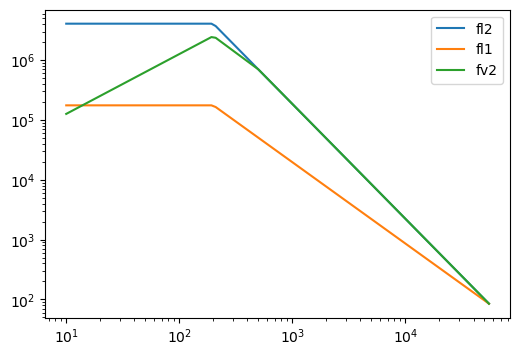

In [31]:
fig, ax = plt.subplots()
for Snu_arr, label in zip(Snu_arrs, labels):
    ax.plot(t_arr, Snu_arr, label=label)
ax.set(xscale='log', yscale='log')
ax.legend()
plt.show()

In [32]:
total = integrate.quad(lambda t: snr.Snu_t_fp(1000, t, tiop='2'), 0, snr.tn)[0]
print(total)

8976885404.239485


In [33]:
total = integrate.quad(lambda t: snr.Snu_t_fl(1000, t, tiop='2'), 0, snr.tn)[0]
print(total)

1693265821.8884728


In [34]:
ph0 = integrate.quad(lambda t: snr.Snu_t_fl(1000, t, tiop='2'), 0, snr.tMFA)[0]/total
ph1 = integrate.quad(lambda t: snr.Snu_t_fl(1000, t, tiop='2'), snr.tMFA, snr.tf)[0]/total
ph2 = integrate.quad(lambda t: snr.Snu_t_fl(1000, t, tiop='2'), snr.tf, snr.tn)[0]/total
print(ph0, ph1, ph2)

0.48059870018321815 0.2975414112312017 0.22185988859020658


### luminosity distribution

In [21]:
L_arr = np.array([4*np.pi*snr.Snu_t_fl(6300, 100, tiop='1')*(snr.d**2) for snr in snr_valid_SG_list])
L_arr *= 9.52141e19 # Jy kpc^2 --> erg/s/Hz

In [22]:
np.mean(np.log10(L_arr))

25.38539330965852

In [20]:
np.mean(np.log10(L_arr))

26.11967552331366

In [23]:
d_arr = np.log10(L_arr) - np.mean(np.log10(L_arr))
np.sqrt(np.dot(d_arr, d_arr)/len(d_arr))

0.942829160031233

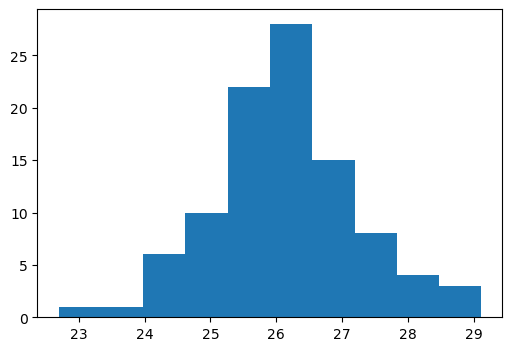

In [16]:
plt.hist(np.log10(L_arr))
plt.show()

In [84]:
snr = get_snr('W28', snr_valid_SG_list)
np.log10(4*np.pi*snr.Snu_t_fl(1000, 45, tiop='2')*(snr.d**2) * 9.52141e19)

28.407498699325583

In [85]:
snr = get_snr('Vela', snr_valid_SG_list)
np.log10(4*np.pi*snr.Snu_t_fl(1000, 300, tiop='2')*(snr.d**2) * 9.52141e19)

25.943674936926634

## Archive

## crude comparison to Vela

In [12]:
import scipy.integrate as integrate

In [13]:
def intSg(snr):
    tpower1 = -0.4*(snr.s+1)
    tpower2 = -0.8*snr.s
    def integrand(t):
        return (np.maximum(t, 100)/snr.tn)**tpower2
    return snr.flux1GHz * integrate.quad(integrand, 0, snr.tn)[0]

In [14]:
Vela = get_snr(GID(263.9,-3.3), snr_valid_wflux_list)
Vela.tf = 500
Vela.tn = 12000
tpw = -1.63
def integrand(t):
    return (np.maximum(t, Vela.tf)/Vela.tn)**tpw
intSg_Vela = Vela.flux1GHz * integrate.quad(integrand, 0, Vela.tn)[0]

In [20]:
c0kpcyr = 0.000306601 # kpc/yr
sigmad_over_c = 160/300000 # (km/s) / (km/s)
blur_sigma = 2*sigmad_over_c*(180/np.pi)*60 # arcmin
print(blur_sigma)

3.666929888837269


In [23]:
print('SNR GID      intSg   *bs^2   size   blur   dist   age      s    loc  other names')
for snr in snr_valid_wflux_list:
    m = intSg(snr)/intSg_Vela
    dDM_max = c0kpcyr * snr.tn/2 # kpc
    blur_max = (1+dDM_max/snr.d) * blur_sigma
    m2 = m*(blur_max/28.3)**-2
    if m > 1 or m2 > 1:
        print('%s  %.3f  %6.3f  %5.1f  %5.1f  %6.3f  %.1e  %.2f  %s   %s' % \
              (snr.ID, m, m2, snr.size, blur_max, snr.d, snr.tn, snr.s, snr.hemisph, snr.name[:40]))

SNR GID      intSg   *bs^2   size   blur   dist   age      s    loc  other names
G000.0+00.0  0.082   4.310    2.9    3.9   8.000  3.5e+03  2.60  S   Sgr A East
G006.4-00.1  19.931  81.511   48.0   14.0   1.876  3.4e+04  2.50  S   W28
G008.7-00.1  0.281   5.685   45.0    6.3   4.382  2.0e+04  2.00  S   (W30)
G018.8+00.3  1.023  13.662   14.0    7.7  13.794  1.0e+05  1.92  S   Kes 67
G021.8-00.6  0.086   3.305   20.0    4.6   5.596  9.0e+03  2.12  S   Kes 69
G023.3-00.3  3.658  10.752   27.0   16.5   4.796  1.1e+05  2.00  S   W41
G031.9+00.0  0.084   3.638    5.9    4.3   7.089  7.9e+03  2.50  S   3C391, Kes 77
G034.7-00.4  0.096   2.581   31.0    5.5   2.632  8.4e+03  1.74  N   W44, 3C392
G039.7-02.0  8.694  67.962   85.0   10.1   4.770  5.5e+04  2.40  N   W50, (SS433)
G049.2-00.7  0.117   3.143   30.0    5.5   5.367  1.7e+04  1.60  N   W51C
G054.4-00.3  0.571   3.771   40.0   11.0   4.667  6.1e+04  2.00  N   (HC40)
G065.1+00.6  0.432   5.159   67.0    8.2   9.295  7.5e+04  2.22  N   G

In [124]:
get_snr('G006.4-00.1', snr_list).spec_ind

0.75

In [126]:
get_snr('G039.7-02.0', snr_list).spec_ind

0.7